# **Group 5 ED(C) Deep Learning Approach with the use of Transformers - Evaluation on the dev set**

Import necessary libraries

In [2]:
from claims_dataset import ClaimEvidenceDataset
from evidence_classifier import EvidenceClassifier
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

Load the dev set

In [3]:
dev_df = pd.read_csv('data/dev.csv')
dev_df.head()

,Claim,Evidence,label
0,Democracy should be done away with.,"Amartya Sen, an Indian economist and Nobel lau...",0
1,Polygamy should be made legal.,The Supreme Court's unanimous decision in Reyn...,1
2,Hunting should be banned,In total it is estimated that Ceauşescu receiv...,0
3,Television should be given up.,Barbera mentioned that they had to either adju...,0
4,Abortions ought to be prohibited.,According to a poll conducted by Angus Reid St...,1


Load the model and output its structure

The 'ED_model_C.pth' model can be downloaded from the following link: https://drive.google.com/drive/folders/1TWv5UKNsNeQGxafx3GQf87Dc8vcp5V8t?usp=sharing

In [4]:
model_path = 'ED_model_C.pth'
model = EvidenceClassifier()
model.load_state_dict(torch.load(model_path))
print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

EvidenceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Define the predict function

In [5]:
def predict(test_csv, model_path):
  # Set device to cuda to run on GPU
  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  # Load the model state dictionary
  model = EvidenceClassifier().to(device)
  model.load_state_dict(torch.load(model_path, map_location=device))

  # load the data to evaluate on (in this case the dev dataset)
  test_dataset = ClaimEvidenceDataset(test_csv)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
  # set the model to evaluation mode
  model.eval()

  all_predictions = []
  all_probabilities = []

  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      labels = batch['labels'].to(device)

      logits = model(input_ids, attention_mask, token_type_ids)
      probabilities = torch.nn.functional.softmax(logits, dim=1)
      predictions = torch.argmax(probabilities, dim=1)

      all_predictions.extend(predictions.cpu().numpy())
      all_probabilities.extend(probabilities.cpu().numpy())


  df = pd.read_csv(test_csv)
  df['prediction'] = all_predictions
  return df

Run the model in inference mode on the dev set and calculate metrics

In [6]:
predictions = predict('data/dev.csv', 'best_model.pth')

true_labels = predictions['label']
predicted_labels = predictions['prediction']

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Accuracy: 0.8766452919338509
Precision: 0.8764849699451085
Recall: 0.8766452919338509


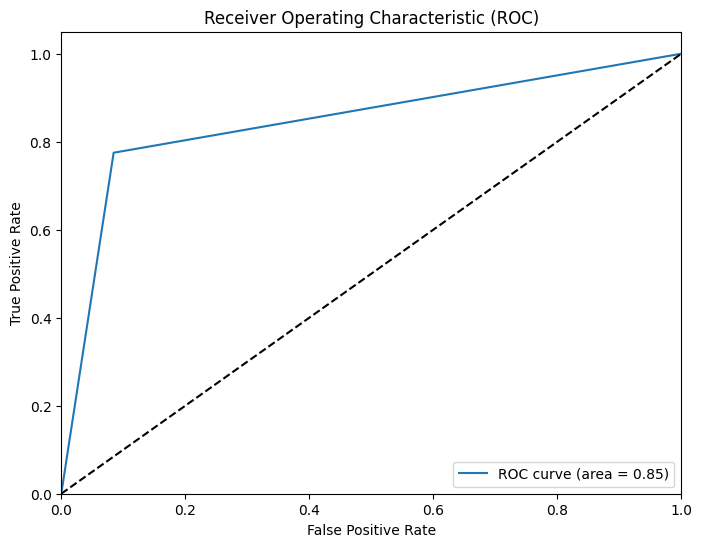

In [7]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Save the predictions

In [8]:
dev_predictions = predictions['prediction']
dev_predictions.to_csv('Group_5_C.csv', index=False)